# PHYS20762 - Project 3 - Monte Carlo

Robert Hartley<br>
University of Manchester <br>
May 2022

## 1. Project Introduction and background information
In the last project we used deterministic numerical integration methods to simulate a spring-mass system. In this projet we shall use a random numerical integration method called the **Monte Carlo Method**. Deterministic iterative methods are numerical methods that, given the same inital conditions, always give back the same outputs. Deterministic methods have linear steps in time, which can cause problems if these time steps have periodicity with the system. For example if you were measuring the average value of $cos(x)$ over 10 cycles using 10 steps. A deterministic method would analyse the function in steps of $2 \pi$ (from 0 to $18 \pi$). The average value for these steps would be 1, which is obviously wrong ~ this is called a **pathological error**. Random numerical methods eliminate this cause for concern by taking 10 random steps in time. This means that once you have run the random numerical method many times the average value will start to converge on the actual value.

The Monte Carlo method, named after the famous Monte Carlo casio, is one of the most well-known numerical methods and was first used during the Manhattan project. It is now used in a variety of systems, from finance to AI. In this project we shall use it to simulate a neutron travelling through matter. This will allow us to study the probabilitity of a material transmitting, back scattering and absorbing neutrons. From this we will also be able to calculate attenuation characteristic distances.

As well as the advantage of not having pathological errors, the Monte Carlo method also excels when higher dimensions are added to the system. In regular integrating [ $\int f(x_1, x_2, ..., x_d) \,dx_1, dx_2, ..., dx_d$ ], the computation time increase rapidly by $N^d$, where $N$ is the number of steps in each dimension $d$. Whereas in Monte Carlo integration, the integration is independent of dimension $d$ and the resulting error is of the order $1/\sqrt(N)$.


### 1.1 Project Aims:
- Show that the selected pseudo-random generator has no preference and is **uniform** over a range
- Create a random number generator that has an **exponential** distribution.
- Create a random number generator that produces **isospherical** points on a sphere.
- Use these two generators to simulate a **neutron path** in matter
- Study the end result of the neutron to get the chance of a neutron being transmitted, absorbed or back scattered by the material
- Find the **probability of transmission** for multiple thicknesses to calculate the attenuation characteristic of different materials
- Use the **Woodcook method** to study neutron paths in **multi-material** situations


#### Initializing the libraries that we will use

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as pc
from scipy.optimize import curve_fit
from datetime import datetime
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
start_time = datetime.now()

Defining constants:


In [63]:
N_A = pc.N_A

WATER_DENSITY = 0.9986 #in g/cm^3
WATER_M_M = 18.01528 #in g/mol
WATER_ABS_CROSS = 0.6652 * 10**-24 #in cm^2
WATER_SCAT_CROSS = 103.0 * 10**-24 #in cm^2
water_values_array = [WATER_DENSITY, WATER_M_M, WATER_ABS_CROSS, WATER_SCAT_CROSS]



LEAD_DENSITY = 11.35 #in g/cm^3
LEAD_M_M = 207.2 #in g/mol
LEAD_ABS_CROSS = 0.158 * 10**-24 #in cm^2
LEAD_SCAT_CROSS = 11.221 * 10**-24 #in cm^2
lead_values_array = [LEAD_DENSITY, LEAD_M_M, LEAD_ABS_CROSS, LEAD_SCAT_CROSS]

GRAPHITE_DENSITY = 1.67 #in g/cm^3
GRAPHITE_M_M = 12.011 #in g/mol
GRAPHITE_ABS_CROSS = 0.0045 * 10**-24 #in cm^2
GRAPHITE_SCAT_CROSS = 4.74 * 10**-24 #in cm^2
graphite_values_array = [GRAPHITE_DENSITY, GRAPHITE_M_M, GRAPHITE_ABS_CROSS, GRAPHITE_SCAT_CROSS]

vacuum_values_array = [0, 0, 0, 0]



## 1.2 Creating a uniformly distributed sample
The random number generator used in this report is the numpy module '$numpy.random.uniform$'. The numpy module uses a Merenne Twister algorithm to generate a random number between two values, with a uniform distribution. The Merenne Twister algorithm was first written in 1997 and passes numerous statistical randomness tests. One of its many advantages is it's very large period of $2^{19937} − 1$, as well as its $2^{32}-1$ unique integer values allows it to produce random numbers with much finer granuality than other methods. It large period and ability to create random numbers quickly allows it to be used widely for Monte Carlo simulations.

In [64]:
def UniformRandomDist(size):
    '''Function to create a random uniform distribution of size: {size}
    Parameters:
    size - float - size of array
    -------
    Return:
    array - numpy array of uniformly distributed random numbers'''
    array = np.random.uniform(0, 1, size)
    return array
        

#### Checking uniformity of the pseduo-random number generator 
To check the uniformity of the pseduo-random number generator, we shall plot the values as a histogram to see if there is equal chance of a range of numbers coming up. We will also look into the variation of the samples as we increase sample size. To do this we use two error techniques, the binominal error and the Gaussian error.
The Gaussian error, which is an approximation when $n$ is high, is defined as 
$$\sigma_G = \sqrt{np},$$
where $n$ is the sample size, and $p$ is the probabiity of getting a value, for our histogram this would be equal to $1/{b}$, where $b$ is the number of bins.
The binominal error follows through from the binonimal theorem and is calculated by $$\sigma_B = \sqrt{\frac{a(n-a)}{n}},$$
where $a$ is the average value and is calculated from $np$.
The Gaussian approximation is when $b$ and $n$ are large, and therefore $n-np$ can be approximated to $n$ at high $n$ and low $p$. This causes the binominal error to go $\sqrt{\frac{n^2p}{n}} = \sqrt{np}$ as expected.

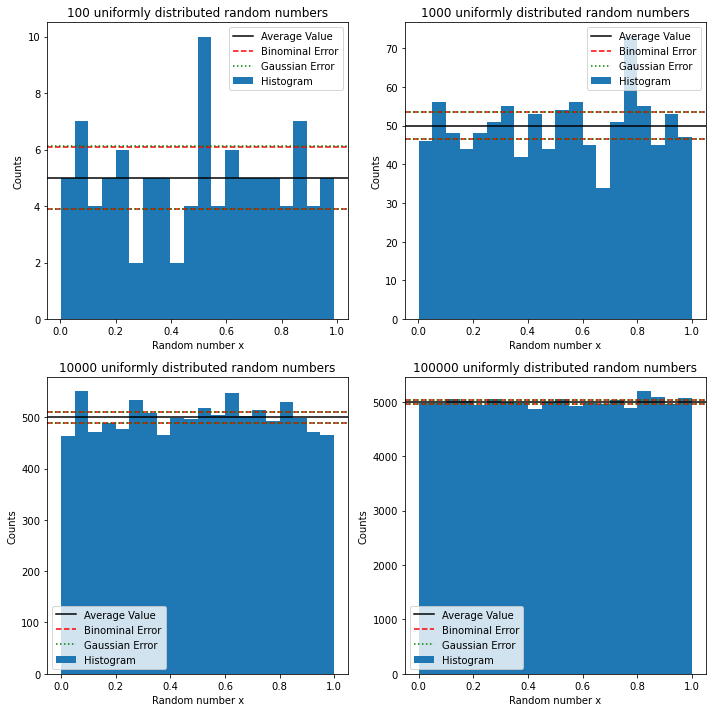

In [65]:
#In each cell, will redefine what backend of matplotlib is being used,
#such that if the cells aren't run in order, it still runs as expected.
%matplotlib inline
import matplotlib.pyplot as plt #Need to re-import matplotlib when the backend changes


sample_nums= [100, 1000, 10000, 100000]
x_array = [[],[],[],[]]

binominal_error = np.zeros(len(sample_nums))
gauss_error = np.zeros(len(sample_nums))
average = np.zeros(len(sample_nums))

bin_num = 20
#Create a for loop that creates a random sample for each element in sample_nums
for index, sample_num in enumerate(sample_nums):

    x_array[index] = UniformRandomDist(sample_num)
    a = sample_num/bin_num
    average[index] = a
    #Calculate the two variations
    gauss_error[index] = np.sqrt(a)
    binominal_error[index] = np.sqrt((a*(sample_num - a))/sample_num)
    
    
fig,((ax_1, ax_2),(ax_3,ax_4)) = plt.subplots(2,2,figsize = (10,10)) #Create figure
axes = [ax_1, ax_2, ax_3, ax_4]

#Create figure to plot 4 histograms of different sample sizes.
for index in range(4):
    axes[index].hist(x_array[index], bins=bin_num, histtype='stepfilled', label='Histogram')
    axes[index].axhline(y=average[index], c='black', label ='Average Value')
    axes[index].axhline(y=(binominal_error[index]/2+average[index]), c='red', linestyle='dashed', label='Binominal Error')
    axes[index].axhline(y=(-binominal_error[index]/2+average[index]), c='red', linestyle='dashed')
    axes[index].axhline(y=(gauss_error[index]/2+average[index]), c='green', linestyle='dotted', label='Gaussian Error')
    axes[index].axhline(y=(-gauss_error[index]/2+average[index]), c='green', linestyle='dotted')    


    axes[index].set_title(str(sample_nums[index]) + ' uniformly distributed random numbers')
    axes[index].set_xlabel('Random number x')
    axes[index].set_ylabel('Counts')
    axes[index].legend()


plt.tight_layout()
plt.show()


As showm in the above plots, as our sample size increases the binominal and Gaussian variations converge on each other. This is expected from our decription of each error and the approximation the Gaussian takes. There is also a much smaller percentage variation as sample size increases. This can be seen from the affect of dividing the variation by the average value, $$\frac{\sqrt{np}}{np} = \frac{1}{\sqrt{np}}.$$
Showing that the percentage varation decreases as $1/\sqrt n$.


## 1.3 Spectral test

Not all pseudo-random generators are uniform without spatial preference. Linear congruential generators (LCGs), like the one below, have a property that causes them to form lines, or planes, on which all possible numbers can be found. These are called spectral lines and causes the distribution to be unsuitable for Monte Carlo simulations [1]. The following function is a RANDSSP Multiplicative congruential uniform random number generator. This generator was used by IBM in several libraries in the 1960's. There is a strong correlation between three consecutive values which causes these spectral planes to occur.

LCG's are represented by the equation;
$$X_{n+1} = (a X_n + c)\mod m $$
where $m$ is the modulus, $a$ is the multiplier, $c$ is the increment and $X_0$ is the seed. These four values need to be chosen very carefully in order to get a good pseudo-random number generator.

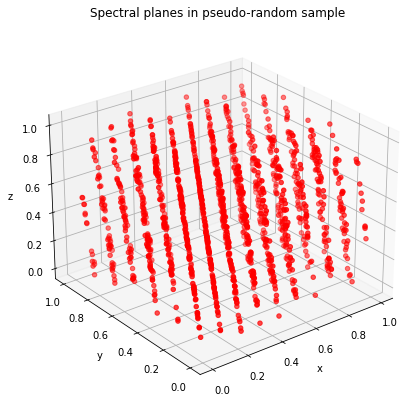

In [66]:
%matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

def randssp(p,q):
    try: x
    except NameError:
        m = pow(2, 31)
        a = pow(2, 16) + 3
        c = 0
        x = 123456789
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a*x + c, m)
            r[k, l] = x/m
    return r
k = randssp(3, 1500)

# Plot the graph
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(k[0, :], k[1, :], k[2, :], color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Spectral planes in pseudo-random sample')
ax.view_init(26, -128)

plt.show()



As seen in the above plot, there are spectral planes where all possible values fall onto. This is a property of all LCGs, and the further apart these planes are, the worse the generator is. The correlation between consectutive values cause the planes.

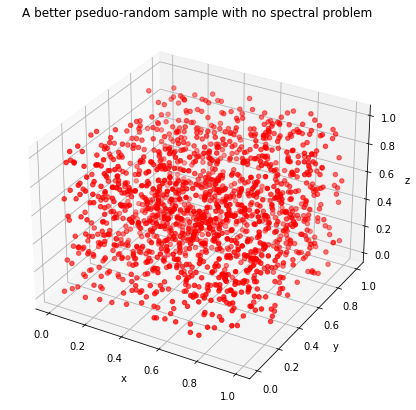

In [67]:
%matplotlib inline
%matplotlib inline

import matplotlib.pyplot as plt

n = 1500
#Create a 3d random sample
x_array = UniformRandomDist(n)
y_array = UniformRandomDist(n)
z_array = UniformRandomDist(n)

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_array, y_array, z_array, color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('A better pseduo-random sample with no spectral problem')
plt.show()

    
    
    
    
    

Using the '$numpy.random.uniform$' function, which uses the Merenne Twist algorithm, the spectral problem dissolves.

**In conclusion we have seen that our chosen pseduo-random number generator is uniform and doesn't have a spectral problem, this proves it is fit for use in our Monte Carlo simulation** 

## 1.4 Determining path length
#### Path length process and theory
In a given material, a neutron has a mean path length, which is defined as the average path length before the neutron has an interaction with another particle. To start with we will only consider absorption interactions in matter. 
The number of molecules, $n$, that can absorb the neutron is given by 
$$n = \frac{\rho N_A}{M}$$
where $\rho$ is the density of matter, $N_A$ is Avogadro's constant and $M$ is the molar mass of the matter.
The number of neutrons absorbed in a thin layer of the material is then given by,
$$N_L = n \sigma I L$$
where $\sigma$ is the absorption cross-section of the material, $I$ is the intensity of the neutron beam and $L$ is the thickness of material. $\sigma$ is a measure of the probability of an absorption process. 

From the above equation we can calculate the rate of aborption per unit thickness,
$$\frac{dI}{dx} = - n \sigma I$$
which can be solved to find the intensity of a neutron beam after travelling distance $x$ in a material;
$$I(x) = e^{-n \sigma x} $$
where $1/n \sigma$ is defined as $\lambda$, the mean free path (MFP).

#### Random exponential distribution
Next we shall write a function to create a sample of random numbers that follow an exponential distribution. To do this we use the inverse distribution method, where you pass a uniform random sample into the inverse of the cumulative distribution. 

For our system, the probability density function (pdf) is 
$$pdf(x) = e^{-x/\lambda}$$
the cumulative distribution (cdf) is then $$cdf (x) = \int_{0}^{\infty} pdf (x) = \lambda(1 - e^{-x/\lambda})$$
the inverse cdf is then $$ {cdf}^{-1}(x) = -\lambda \ln(1 - \frac{x}{\lambda})$$.
Now we replace x with a uniformally distributed random number, $u_{i}$, to get an exponential distribution.
We also note that $1 - \frac{u_i}{\lambda}$ is just another uniformallly distributed number, so our final expression for our distribution is 
$$ s_i = -\lambda \ln(u_i)$$
#### Fitting the data to work out the mean free path
Once we have our exponentially distributed random sample, we can fit the data to the original pdf in order to work out the mean free path. The pdf is represented as;
$${pdf} = Ae^{-x/\lambda},$$
where $A$ is a constant factor, as it is no longer an equation of probability, but of total counts. We can take the log of both sides to get,
$$\ln(y) = \ln A - \frac{x}{\lambda}.$$
This allows us to calculate the gradient on a straight line graph and relate it back to the mean free path as $-1/m$, where $m$ is the calculated gradient.

In [68]:
def ExponentialRandomDist(sample_num, density, molar_mass, cross_sect):
    '''
    Function to create a random sample that is exponentially distributed.
    Parameters:
    sample_num - length of sample created - integer
    density - density of material - float
    molar_mass - molar mass of material - float
    cross_sect - cross section of absorption for material - float
    Returns:
    -------
    exp_array - array of length sample_num exponentially distributed - array of floats
    '''
    mfp = molar_mass / (density*N_A*cross_sect)
    exp_array = -mfp * np.log (np.random.uniform(0, 1, sample_num))
    
    return exp_array
    

In [69]:
def PathLengthFunc(data, mfp, A_0):
    '''
    Function used to fit data to an exponential curve.
    Parameters:
    data - x value of data getting fitted to curve - array of floats
    mfp - mean free path of curve / data - float
    A_0 - initally intensity of sample - float
    ------
    Returns:
    Y - y values corresponding with x according to fitted function - array of floats
    '''
    
    return A_0*np.exp(-data/mfp)

In [70]:
def ExponentialHistFit(bin_heights, bin_edges, errs, threshold, bin_num = 100):
    '''
    Function to fit a histogram to an exponential curve
    Parameters:
    exponential_dist - array of values from a random exponential distribution - array of floats
    bin_num - number of bins used in histogram - integer
    -----
    Returns
    coef - coeficient of linear fit gradient and constant - array
    cov - covariant matrix where diagonal gives the error on each variable squared - 2x2 matrix (2x2 array)
    new_bin_edges - bin edges to get the max value to plot.
    '''
    #Difference inbetween each bin is the width
    bin_widths = np.diff(bin_edges)
    #Calculate the centre of each bin
    bin_centres = bin_edges[:-1] + bin_widths / 2
    

    up_to = np.where(bin_heights<=threshold)[0] #Define where to cut graph off at

    if up_to.size > 0:
        
        #Stop histogram at first 0 value
        bin_heights = bin_heights[:up_to[0]]
        bin_centres = bin_centres[:up_to[0]]
        bin_edges = bin_edges[:up_to[0]]
        bin_widths = bin_widths[:up_to[0]]
    else:
        up_to = [len(bin_heights)]
        
    ln_data = np.log(bin_heights)
    if type(errs) == int: #If fit has no weighting
        
        coef, cov = np.polyfit(bin_centres, ln_data, 1, cov=True)
    else: 
        #If we do have a weighting
        errs = errs[:up_to[0]]
        coef, cov = np.polyfit(bin_centres, ln_data, 1, cov=True, w =  1/errs)
       
    
    return coef, cov, [bin_heights, bin_edges, bin_centres, bin_widths, errs], up_to[0]
    

    

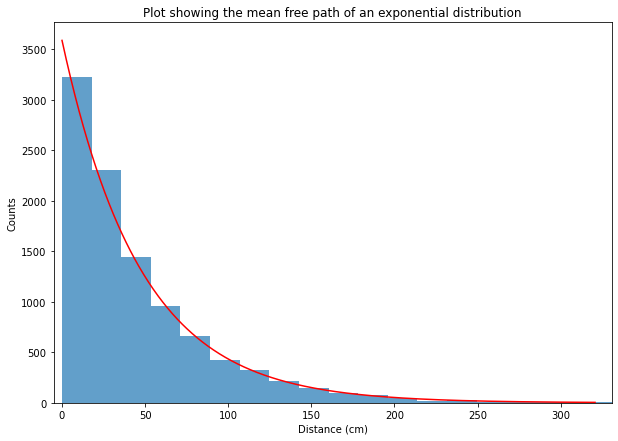

The mean path length is 47.33 +/- 0.0007cm


In [71]:
%matplotlib inline
bin_num = 20

#Calculate exponential random distributition for water
water_path_length = ExponentialRandomDist(10000, 1, WATER_M_M, WATER_ABS_CROSS)

bin_heights, bin_edges = np.histogram(water_path_length, bins=bin_num)
#Fit the data
coef, cov, bin_data, _ = ExponentialHistFit(np.array(bin_heights), np.array(bin_edges), 0, 2, bin_num=bin_num)
bin_edges = bin_data[1]

x_range = np.linspace(bin_edges[0], bin_edges[-1], 1000)

plt.rcParams["figure.figsize"] = (10,7)


plt.plot(x_range, PathLengthFunc(x_range, -1/coef[0], np.exp(coef[1])), label='fit', c='red')
plt.hist(water_path_length, bin_num,  alpha = 0.7)
plt.title('Plot showing the mean free path of an exponential distribution')
plt.xlabel('Distance (cm)')
plt.ylabel('Counts')
#Put a x limit on plot.
plt.xlim(xmin=-5, xmax = bin_edges[-1]+10)

plt.show()
print('The mean path length is {:.2f} +/- {:.4f}cm'.format(-1/coef[0], np.sqrt(cov[0][0])))


As seen in the histrogram above this random exponential distribution follows the equation that we expect closely. This again allows this distribution to be used in our Monte Carlo simulation. The error above is the error on the fit values, and doesn't take into account the natural uncertainty and oscillation around the true value that occurs fro the random sample. It should be pointed out that the calculated mean path length is not exactly the inputted mean free path (of $\lambda_{True} = 44.972 cm$

To investigate this more, we shall perform the fitting function 100 times, each with a random sample of 10,000 values to calculate a more accurate value of the mean path length as well as estimate the variation and error of the value.

### Error of the mean free path
We now produce 100 samples, each of 10,000 neutrons in order to work out the standard deviation of our calculated value. As described in the above section, the plot is of the function $\ln(y) = \ln A - \frac{x}{\lambda}$. 
From the propogation of errors theorem we know that the error on the logged y axis can be calculated from;
$$\sigma_{\ln y}^2 = (\frac{\partial {\ln y}}{\partial y})^2 \sigma_y^2$$
which means $$\sigma_{\ln y} = \frac{\sigma_y}{y}.$$
This provides us the weighting on our fit of $1/\sigma_{\ln y}$.
By combining the weighting with the error from our fit (which includes the error on $\ln y$) we get a total error on the mean free path of $$\sigma_{\lambda} = \frac{\sigma_{fit}}{\lambda ^2}$$

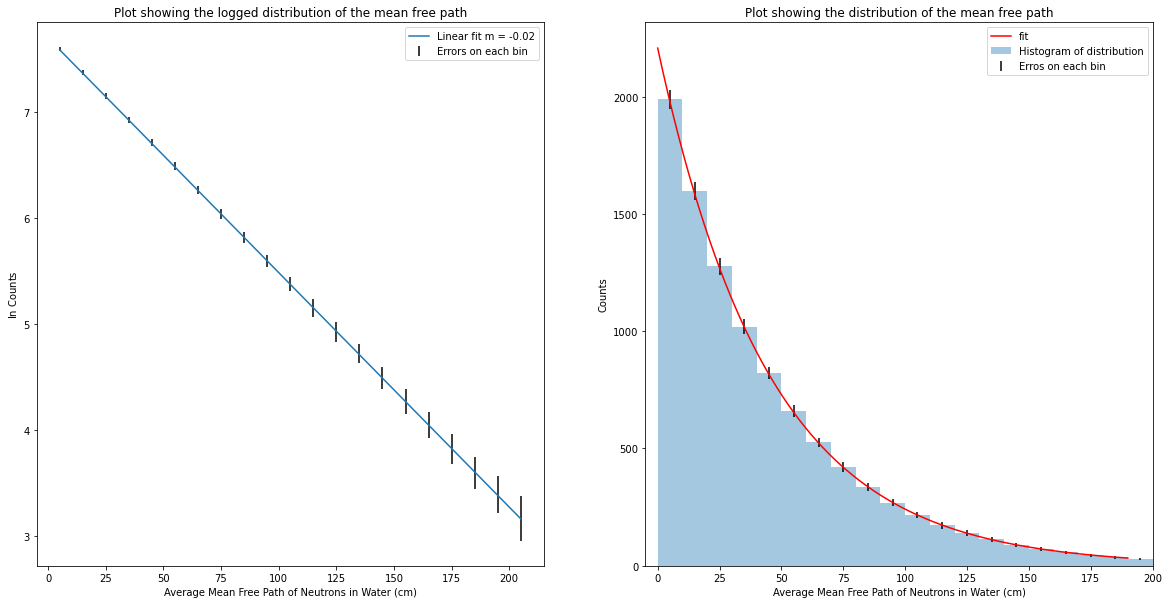

The mean path length is 45.20 +/- 0.086cm


In [72]:
mfps = []
iterations = 100
num_samples = 10000

bin_num = 100
covs= []
bin_heights_array = np.zeros([iterations, bin_num])
#For each iteration, create a random sample and append to an array of frequencies
for i in range(iterations):
    water_path_length = ExponentialRandomDist(num_samples, 1, WATER_M_M, WATER_ABS_CROSS)
    bin_heights, bin_edges = np.histogram(water_path_length, bins=bin_num, range=(0, 10*bin_num))
    bin_heights_array[i] = (bin_heights)

#Calculate mean and std of each bin
total_bin_heights = np.array(np.mean(bin_heights_array, axis = 0))
std_heights = np.std(bin_heights_array, axis = 0)

#Fit using mean and std as above
coef, cov, bin_data, up_to = ExponentialHistFit(total_bin_heights, bin_edges, std_heights, 20)

bin_heights = bin_data[0]
bin_edges = bin_data[1]
bin_centres = bin_data[2]
std_heights = bin_data[4]

#Draw figure
fig,(ax_1, ax_2) = plt.subplots(1,2,figsize = (20,10))

x_range = np.linspace(bin_edges[0], bin_edges[-2], 1000)

ax_1.errorbar(bin_centres, np.log(bin_heights), (std_heights)/bin_heights, c='black', fmt= ' ', label='Errors on each bin')
ax_1.plot(bin_centres, coef[0]*bin_centres + coef[1], label = 'Linear fit m = {:.2f}'.format(coef[0]))


ax_2.bar(bin_centres, bin_heights, width = bin_edges[1] - bin_edges[0], alpha =0.4, label='Histogram of distribution')
ax_2.errorbar(bin_centres, bin_heights, yerr=std_heights, c='black', fmt=' ', label= 'Erros on each bin')
ax_2.plot(x_range, PathLengthFunc(x_range, -1/coef[0], np.exp(coef[1])), label='fit', c='red')

ax_1.legend()
ax_2.legend()

#Put a x limit on plot.
plt.xlim(xmin=-5, xmax = bin_edges[-1])
ax_1.set_title('Plot showing the logged distribution of the mean free path')
ax_2.set_title('Plot showing the distribution of the mean free path')

ax_1.set_xlabel('Average Mean Free Path of Neutrons in Water (cm)')
ax_2.set_xlabel('Average Mean Free Path of Neutrons in Water (cm)')

ax_1.set_ylabel(r'$\ln$ Counts')
ax_2.set_ylabel('Counts')

plt.show()


total_err = (np.sqrt(cov[0][0]) / coef[0] ** 2)
print('The mean path length is {:.2f} +/- {:.3f}cm'.format(-1/coef[0], total_err))
#Combine fitting error with natural error from variation in mfp


As you can see from this plot, even with 100 iterations, the standard deviation on each bin is still very large and still varies with each iteration, this is due to the Monte Carlo system being inherently random.
Here the error was calculated from the fitting error divded by the actual value squared. This is due to the weighting we put on the fit. The weighting comes from the inverse of the logged errors, such that the lower distances are more significant. 

The calculated value is in one standard deviation of the true value (most of the time), once again showing a good distribution.

## 1.5 Scattering Process
The next step towards creating a full simulation is to include interactions with matter that cause scattering. Scattering creates another step which is isotropic in direction and with radius still distributed by the mean free path.
To determine which process happens at each interaction, we calculate the probabilities of each process using the macroscopic cross section, $\Sigma$,  which is defined as $n \sigma$.

The probability of absorption is then 
$$\frac{\Sigma_a}{\Sigma_a + \Sigma_s}.$$
The probability of scattering is then,
$$\frac{\Sigma_s}{\Sigma_a + \Sigma_s},$$
where $\Sigma_a$, $\Sigma_s$ are the macroscopic cross sections of absorption and scattering respectively.
### 1.5.1 Isotropic sphere distribution
First of all we need to create a distribution that is isotropically distributed along a unit sphere.
To do this we create a uniformally distributed random sample as before and convert them into theta and phi angles.
The phi, $\phi$, angles are easy to do and are done by just multiplying by $2 \pi$ to get a randomly distributed sample between 0 and $2 \pi$. Theta, $\theta$, takes more effort, where you have to multiply by a function, as angles close to 0 and $\pi$ will be more populated (when transformed into cartesian coordiantes) - causing preference and poles of higher concentration. This is solved by using the function;
$$\theta_i = arccos(1-2 u_i)$$
which has a lower concentration close to 0 and $\pi$, counteracting the problem caused earlier.
We then convert these values into cartesian coordiantes to update to the position of the neutron.

In [73]:
def IsoSphereRandomDist(num, r=1):
    '''
    Function to generate isotropic random numbers on a unit sphere
    Parameters:
    num - size of random sample created - integer
    r - radius of step r=1 for a unit sphere - integer
    -----
    Radius:
    X - random sample of X positions - array of floats
    Y - random sample of Y positions - array of floats
    Z - random sample of Z positions - array of floats'''
    rand_sample = np.random.uniform(0, 1, num)
    thetas = np.arccos(1 - 2*rand_sample)  #Use the inverse cosine function to get rid of poles of concentration
    phis = 2*np.pi * np.random.uniform(0, 1, num)
    
    X = r*np.sin(thetas)*np.cos(phis)
    Y = r*np.sin(thetas)*np.sin(phis)
    Z = r*np.cos(thetas)
    

    
    return X, Y, Z

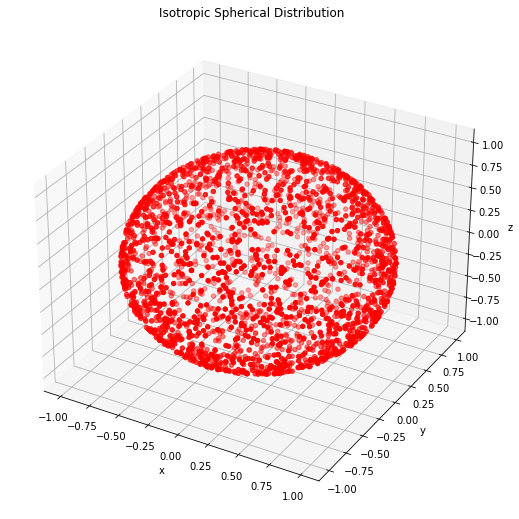

In [74]:
x_array, y_array, z_array = IsoSphereRandomDist(2500)


#Create 3d plot
fig = plt.figure(figsize=(9,9))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_array, y_array, z_array, color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Isotropic Spherical Distribution')
plt.show()


As seen in the above plot, there are no poles present on the unit sphere, so no preference towards values, once again allowing this function to be used in our Monte Carlo simulation. 

### 1.6 Exponentially distributed isotropic steps
The next step is to generate exponentially distributed isotropic steps, by multiplying the unit sphere by a radius given by the random exponential distribution. This will allow us to finally model how the neutrons will act when scattered inside the material. We will also produce a plot of 10,000 exponentially distributed isotropic steps from (0, 0, 0). 

In [75]:
def IsoExponentialStepsDist(num, density, molar_mass, cross_sect):
    '''
    Function to create an array of isotropic steps with a radius relating to the MFP of the material.
    Parameters:
    num - number of sample - integer
    density - density of material - float
    molar_mass - molar mass of material - float
    cross_sect - cross section of absorption in material - float
    ------
    Returns
    x_array - array of x values from each step - array of floats
    y_array - array of y values from each step - array of floats
    z_array - array of z values from each step - array of floats
    '''
    radii = ExponentialRandomDist(num, density, molar_mass, cross_sect)
    x_array, y_array, z_array = IsoSphereRandomDist(num, r=radii)

    return x_array, y_array, z_array

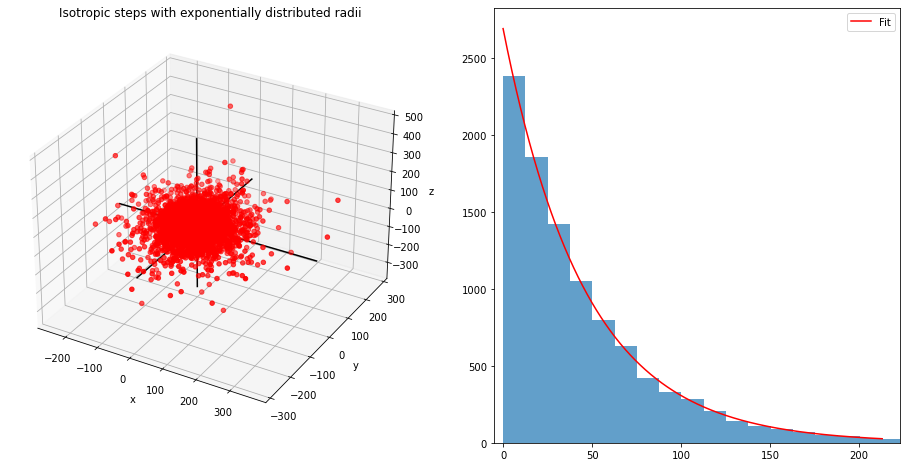

The mean path length is 46.06 cm


In [76]:
%matplotlib inline
%matplotlib inline

import matplotlib.pyplot as plt


bin_num = 40
x_array, y_array, z_array = IsoExponentialStepsDist(10000, 1, 18, 0.665*10**-24)
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(16,8))

ax_1 = fig.add_subplot(121, projection='3d')
ax_1.scatter(x_array, y_array, z_array, color='r')
ax_1.scatter(0,0,0, c='black', s=100)

#central axis
ax_1.plot([max(x_array), min(x_array)],[0,0],[0, 0], c='black')
ax_1.plot([0,0],[max(y_array), min(y_array)],[0, 0], c='black')
ax_1.plot([0,0],[0, 0],[max(z_array), min(z_array)], c='black')

ax_1.set_xlabel('x')
ax_1.set_ylabel('y')
ax_1.set_zlabel('z')
ax_1.set_title('Isotropic steps with exponentially distributed radii')

#Set up figure to show mean free path in r
ax_2 = fig.add_subplot(122)
path_distances = np.sqrt(x_array**2 + y_array**2 + z_array**2)
bin_heights, bin_edges = np.histogram(path_distances, bins = bin_num)
coef, cov, bin_data, _ = ExponentialHistFit(bin_heights, bin_edges, 0, 20) 

bin_heights = bin_data[0]
bin_edges = bin_data[1]
bin_centres = bin_data[2]



#fit_values, fit_errors = curve_fit(PathLengthFunc, bin_centers, bin_heights, p0=[45., 10000])
x_range = np.linspace(bin_edges[0], bin_edges[-1], 10000)

ax_2.hist(path_distances, bins=bin_num, alpha=0.7)

ax_2.plot(x_range, PathLengthFunc(x_range, -1/coef[0], np.exp(coef[1])), label='Fit', c='red')

ax_2.set_xlim(xmin=-5, xmax = bin_edges[-1]+10)
plt.subplots_adjust(wspace=0.2)

#plt.tight_layout()
plt.legend()
plt.show()
print('The mean path length is {:.2f} cm'.format(-1/coef[0]))



As seen in the plots above, the mean free path of the isotropic steps is still around 45cm as expected, and there is no preference in direction - as expected from the two functions we wrote before. This now confirms that this function can be used to simulate scattering in a material in our Monte Carlo simulation

## 2 Full simulation of neutrons travelling through matter.
We can now combine the two processes we have modelled, absorption and scattering, to create a full model of the interactions of neutrons. To do this we need to be able to determine when a neutron hits a particle in the material, if it will scatter or be absorbed.
First we introduce a stop check, this is run at every collsion of the neutron, and will return the state of the neutron if it has transmitted through the material, been back scattered or absorbed - the former two use checks against the neutrons $x$ position against the thickness of the material and return the relevant state if flagged. Absorption uses a uniform random number $u_a$, and if this number is less than the probability of absorption $\frac{\Sigma_a}{\Sigma_a + \Sigma_s}$ (as described in Section 1.5) then the neutron gets absorbed.

### 2.1 Generating path histories
We can now create a function that calculates and stores the path of the neutron. We first do an exponential step in only the $x$ direction as we assume that the neutron source is an infinite distance away, and thus incident neutrons are perpendicular to the slab of material, thus the first step is only in the $x$ direction. We then add an isotropic exponential step to our current values of $x$, $y$ and $z$ respectively and appended these values to our path history array. This gets repeated until the stop checker, as mentioned above, returns a state that is not 'Scattered'

In [77]:
def StopCheck(x, T, abs_cross, scat_cross, u_a):
    '''
    Function to determine the interaction that occurs when a neutron collides.
    Parameters :
    x - posititon of neutron - float
    T - maximum thickness (x direction) of material - float
    abs_cross - absorption cross-section of material - float
    scat_cross - scattering cross-section of material - float
    u_a - uniform random number used to determine if the neutron has been absorbed - float
    ---------
    Returns:
    state - Transmitted, Back Scattered, Absorbed or Scattered 
            depending on the outcomes of the multiple if statements
    '''
    if x > T:
        return 'Transmitted'
    if x < 0:
        return 'Back Scattered'
    if u_a < abs_cross/(abs_cross + scat_cross):
        return 'Absorbed'
    else: 
        return 'Scattered'

In [78]:
def PathHistory(density, molar_mass, abs_cross, scat_cross, T):
    '''
    Function to generate the path of a neutron as it travels through matter.
    Parameters :
    density - density of material - float
    molar_mass - molar mass of material - float
    abs_cross - absorption cross-section of material - float
    scat_cross - scattering cross-section of material - float
    T- maximum thickness (x direction) of material - float
    ---------
    Returns:
    x_array, y_array, z_array - arrays of x, y and z for each step the neutron takes - arrays of floats
    end_state - The state of the neutron - returned from the last call of StopCheck - string
    count - the amount of steps the neutron has taken before ending - int
    '''

    
    n = density*N_A/molar_mass
    cross_section = abs_cross + scat_cross
    #Calculate first step in x direction only
    x = ExponentialRandomDist(1, density, molar_mass, (cross_section))[0]
    y = 0
    z = 0
    #Initalize neutron history in each direction
    x_path = [0, x]
    y_path = [0, 0]
    z_path = [0, 0]
    
    count = 0
    end_state = 'Scattered'  
    
    u_a = np.random.uniform()
    while end_state == 'Scattered':
        count += 1  #Increment step number by one
        #Create isotropic step
        dx, dy, dz = IsoExponentialStepsDist(1, density, molar_mass, (cross_section))
        #Add distance to each array
        x += dx[0]
        y += dy[0]
        z += dz[0]
        #Append new position to history
        x_path.append(x)
        y_path.append(y)
        z_path.append(z)

        u_a = np.random.uniform()
        #Calculate what interaction happens at new position
        end_state = StopCheck(x, T, abs_cross, scat_cross, u_a)
  
    return x_path, y_path, z_path, end_state, count

        
        
        

In [79]:
def NeutronPathFinder(function, density,molar_mass, abs_cross, scat_cross, T, count_lim = 5000):
    '''
    Function to keep generating path histories until all three end states are found, or max iterations is reached.
    Parameters :
    function - function used to create plots (Normal or Woodcock) - float
    density - density of material - float
    molar_mass - molar mass of material - float
    abs_cross - absorption cross-section of material - float
    scat_cross - scattering cross-section of material - float
    T - maximum thickness (x direction) of material - float
    count_lim - max amount of iterations before stop running - integer
    ---------
    Returns:
    all_arrays - 2d array of length 3. In each element there are three arrays, one for each axes. 
                 The three axes arrays all have length of the amount of steps taken - np.ndarray
    step_sizes - array of length 3 that shows how many steps each neutron took - array
    '''
    #path plot of    x.    y.    z.  
    all_arrays = [[[0,0],[0,0],[0,0]],
                  [[0,0],[0,0],[0,0]],
                  [[0,0],[0,0],[0,0]]]
    
    step_sizes = [0, 0, 0]
    absorbed = False
    transmitted = False
    backscattered = False
    
    count = 0
    #Create while loop that stops when you have one history of each outcome, or has run more than count_lim
    
    while (not absorbed or not transmitted or not backscattered) and count<count_lim:
        count +=1
        #Generate a neutrons path history
        x_array, y_array, z_array, end_state, steps = function(density, molar_mass, abs_cross, scat_cross, T)
        #Check what the end state of the neutron was
        if end_state == 'Transmitted':
            if not transmitted:
                transmitted = True
                all_arrays[0] = [x_array, y_array, z_array]
                step_sizes[0] = steps
            

        elif end_state == 'Back Scattered':
            if  not backscattered:
                backscattered = True
                all_arrays[1] = [x_array, y_array, z_array]
                step_sizes[1] = steps

        else:
            if not absorbed:
                absorbed = True
                all_arrays[2] = [x_array, y_array, z_array]
                step_sizes[2] = steps

    return all_arrays, step_sizes


In [80]:
def NeutronPathPlot(material, arrays, boundaries, steps):
    '''
    Function to plot neutron path histories for each material.
    Parameters :
    material - material the neutron is travelling through, passed in for labels - string
    arrays - numpy array containing x, y and z data for each path - np.ndarray
    boundaries - thickness for one material simulations, array of thicknesses for multi-material simulations 
                - floats or array of floats
    steps - array of the amount of steps each path has taken - array of integers
    ---------
    Output :
    One graph of up to three different paths of neutrons in matter.
    '''
    %matplotlib inline
    %matplotlib inline
    import matplotlib.pyplot as plt
    %matplotlib inline
    

    #Create labels and colours of each process for the graph
    labels = ['Transmitted Particle in ' + str(steps[0]) +' steps',
              'Back Scattered Particle in ' + str(steps[1]) +' steps',
              'Absorbed Particle in ' + str(steps[2]) +' steps']
    colours = ['#2d00b8', '#bc0d00', '#00a95a']
    
    fig = plt.figure(figsize=(10,10))
    
    #If single-material system
    if isinstance(boundaries, int):
        boundaries=[0, boundaries]

    ax = fig.add_subplot(111, projection='3d')
    #Calculate range of y and z axis for graph
    min_z_value = np.min([np.min(arrays[0][2]), np.min(arrays[1][2]), np.min(arrays[2][2])])
    max_z_value = np.max([np.max(arrays[0][2]), np.max(arrays[1][2]), np.max(arrays[2][2])])
    
    min_y_value = np.min([np.min(arrays[0][1]), np.min(arrays[1][1]), np.min(arrays[2][1])])
    max_y_value = np.max([np.max(arrays[0][1]), np.max(arrays[1][1]), np.max(arrays[2][1])])
    
   
    z = np.linspace(min_z_value - 1, max_z_value + 1 , 100)
    y = np.linspace(min_y_value - 1, max_y_value + 1, 100)
    z, y = np.meshgrid(z, y)
    #Create planes in 3d plot
    for boundary in boundaries:
        x = 0 * z + 0 * y + boundary

        ax.plot_surface(x, y, z, alpha = 0.3)   
    #Catch case of no outcome
    for index, array in enumerate(arrays):
        
        if len(array[0]) < 3:
            print('There Was No ' + labels[index] + ' in ' + material)
        else:
                
            ax.plot(array[0], array[1], array[2], color=colours[index], label=labels[index])
            ax.scatter(array[0][-1],array[1][-1], array[2][-1], c='r')
            
    #Create label for end and start points
    ax.scatter(0, 0, 0, c='r', label='End Point')
    ax.scatter(0, 0, 0, c='b', label='Start Point')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(9, -81)
    ax.set_title('Neutron paths in '+material)
    ax.legend()

    plt.show()



## Neutron paths in materials
We now plot the paths of neutrons in materials, to see how they evolve over distance.

In [81]:
T = 10

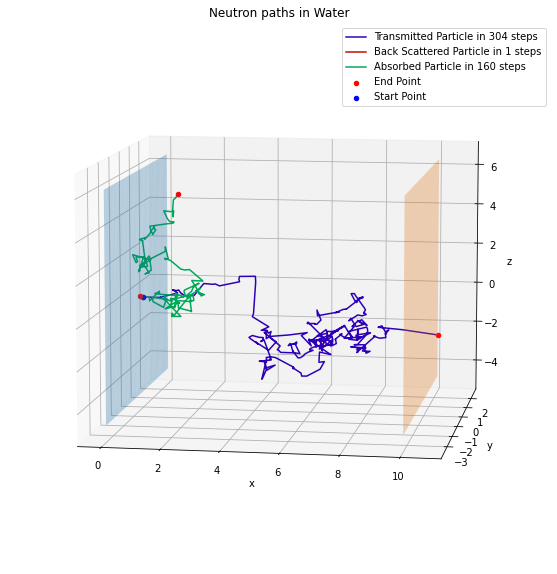

In [82]:
w_arrays, steps = NeutronPathFinder(PathHistory, *water_values_array, T)
NeutronPathPlot('Water', w_arrays, T, steps)

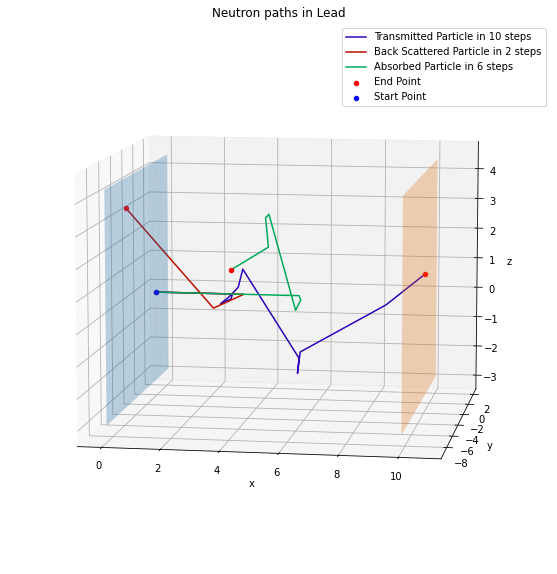

In [83]:
l_arrays, steps = NeutronPathFinder(PathHistory, *lead_values_array, T)
NeutronPathPlot('Lead', l_arrays, T, steps)

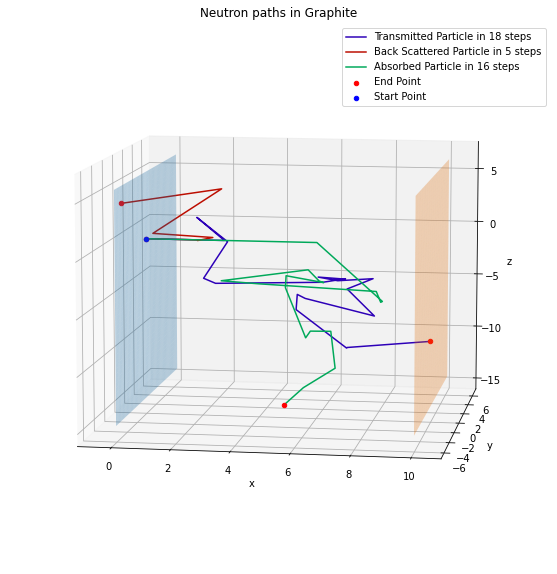

In [84]:
g_arrays, steps = NeutronPathFinder(PathHistory, *graphite_values_array, T)
NeutronPathPlot('Graphite', g_arrays, T, steps)

These three graphs are, by nature, very random and quite hard to get any quantitative data out of. It is much easier to see trends when you start iterating lots of times and looking at probablities and averages. As such, this is what we are going to be doing in the next section.

## 2.2 Probabilities of interactions with neutrons

Now we want to study how these neutrons will propogate through material in more detail.

To reduce the randomness of our results, we shall increase the sample size, (to get less variation as mentioned above in Section 1.2) as well as taking multiple iterations to average over them. We can then use the binominal uncertainty to calculate the standard deviation.

To do this we need to write a new function that is much quicker at returning the final product of a large number of neutrons. First we completely ignore the $y$ and $z$ directions, as they don't impact when each neutrons stop. We next create a list of $n$ first positions of neutrons (each generated from the exponential step). We then perform our stopping conditions - and store the indexs at which they happen, such that we can delete those neutrons from our list of positions. Next we perform the next step by adding the $x$ part of an isotropic exponential step to our previous array of positions. This carries on until the length of our positions array is 0 and hence all neutrons have been stopped or 'killed'.

In [85]:
def SimulateNeutrons(num_neutrons, density, molar_mass, abs_cross, scat_cross, T):
    '''
    Function to calculate final states of many neutrons.
    Parameters:
    num_neutrons - number of starting neutrons - integer
    density - density of material - float
    molar_mass - molar mass of material - float
    abs_cross - absorption cross-section of material - float
    scat_cross - scattering cross-section of material - float
    T - maximum thickness (x direction) of material - float
    --------
    Returns:
    num_transmit/num_neutrons - probability of transmission - float
    num_backscatter/num_neutrons - probability of backscattering - float
    num_absorb/num_neutrons - probability of absorption - float
    '''
    #Defining how we count number of incidences
    num_transmit = 0
    num_backscatter = 0
    num_absorb = 0
    #Making new variables for ease of use later
    cross_section = abs_cross + scat_cross
    abs_prob = abs_cross/cross_section
    
    #Array of first x positions for each neutron
    x_pos = ExponentialRandomDist(num_neutrons, density, molar_mass, (cross_section))
    while len(x_pos) != 0:
        #Array of random numbers to work out if each neutron is absorbed
        rand_sample = np.random.uniform(0, 1, len(x_pos)) 
        
        num_transmit += len(np.argwhere(x_pos>T))
        num_backscatter += len(np.argwhere(x_pos<0))
        num_absorb += len(np.argwhere(rand_sample<abs_prob))
        
        #Delete all neutrons that have been killed
        x_pos = np.delete(x_pos, np.argwhere( (x_pos>T) | (x_pos<0) | (rand_sample<abs_prob)))
        
        #Add our next step
        x_pos += IsoExponentialStepsDist(len(x_pos), density, molar_mass, cross_section)[0]
        
    return (num_transmit/num_neutrons, num_backscatter/num_neutrons, num_absorb/num_neutrons)
        
        

We now need to write a function that can run the *SimulateNeutrons* function multiple times, such that we can create an average of each outcomes probability.

In [86]:
def Probabilities(num_neutrons, iterations, T):
    '''
    Function to generate the average probabilties for each outcome in each material.
    Parameters:
    num_neutrons - number of neutrons being sampled - integer
    iterations - number of iterations to do before returning average - integer
    T - thickness of material - float
    -------
    Returns:
    total_w_probs - the total water probabilties for each outcome on each iteration - 3xiterations matrix - np.ndarray
    total_l_probs - the total lead probabilties for each outcome on each iteration - 3xiterations matrix - np.ndarray
    total_g_probs - total graphite probabilities for each outcome - 3 x iterations matrix - np.ndarray    
    '''
    
    total_w_probs = np.zeros([iterations, 3])
    total_l_probs = np.zeros([iterations, 3])
    total_g_probs = np.zeros([iterations, 3])
    #For loop to find probabilities of each outcome several times
    for index in range(iterations):
        water_probs = SimulateNeutrons(num_neutrons, *water_values_array, T)    
        total_w_probs[index] = water_probs
        
        lead_probs = SimulateNeutrons(num_neutrons, *lead_values_array, T)    
        total_l_probs[index] = lead_probs
        
        graphite_probs = SimulateNeutrons(num_neutrons, *graphite_values_array, T)    
        total_g_probs[index] = graphite_probs         
    return total_w_probs, total_l_probs, total_g_probs
    

We can now call these functions and calculate the mean value and standard deviation on each outcome.

In [87]:
T = 10 #cm
num_neutrons = 1000
iterations = 7

total_w_probs, total_l_probs, total_g_probs = Probabilities(num_neutrons, iterations, T)
total_w_probs = total_w_probs * 100
total_l_probs = total_l_probs * 100
total_g_probs = total_g_probs * 100

mean_water_prob = np.mean(total_w_probs, axis=0)
mean_lead_prob = np.mean(total_l_probs, axis=0)
mean_graphite_prob = np.mean(total_g_probs, axis=0)

std_water_prob = np.std(total_w_probs, axis=0)
std_lead_prob = np.std(total_l_probs, axis=0)
std_graphite_prob = np.std(total_g_probs, axis=0)


We now display the data in a table

In [88]:
##Create pandas table to output data

data = [["Water", mean_water_prob[0], 100*std_water_prob[0]/mean_water_prob[0],
         mean_water_prob[1], 100*std_water_prob[1]/mean_water_prob[1],
         mean_water_prob[2],  100*std_water_prob[2]/mean_water_prob[2]], 
        ["Lead", mean_lead_prob[0], 100*std_lead_prob[0]/mean_lead_prob[0],
         mean_lead_prob[1], 100*std_lead_prob[1]/mean_lead_prob[1],
         mean_lead_prob[2], 100*std_lead_prob[2]/mean_lead_prob[2]],
        ["Graphite", mean_graphite_prob[0], 100*std_graphite_prob[0]/mean_graphite_prob[0],
         mean_graphite_prob[1], 100*std_graphite_prob[1]/mean_graphite_prob[1],
         mean_graphite_prob[2], 100*std_graphite_prob[2]/mean_graphite_prob[2]]]

prob_df = pd.DataFrame(data, columns=["Material", "Transmission probability %", "Tr Error %",
                                      "Back Scatter probability %", "Bs Error %", 
                                      "Absorption probability % ", "Abs Error %"])
prob_df.round(2)





,Material,Transmission probability %,Tr Error %,Back Scatter probability %,Bs Error %,Absorption probability %,Abs Error %
0,Water,0.34,46.40,79.14,0.97,20.97,4.31
1,Lead,28.07,3.38,61.56,1.61,11.57,5.76
2,Graphite,30.06,4.98,69.17,2.13,0.80,25.88


Here we see that water is by far the most attenuating, with a transmission probability of less than 0.5%. It also then has the biggest backscatter and absorption probabilities. This could be due to its absorption and scattering cross sections being larger than both lead and graphites. Water also has less variations in its probabilities, which could be due to the fact that it has the shortest mean free path meaning, on average, neutrons have to take more steps in a water than the other two materials. This would cause the randomness from our exponential functions to be slightly minimized as we are taking more samples / steps. Graphite varies quite a bit and this could be due to its relatively low density and cross sections, inducing more randomness into the simulations - the opposite of water, as mentioned above.

## 2.3 Effect of changing N on error
We will now look at how the error on each probablitity changes as we change $N$. Using the binominal expansion, we expect the error to be reduced by $(1/ \sqrt N)$. 

We first create a *for loop* that calls the function to calculate probabilties once for each sample size we are using. Each time we calculate the probabilties, we are running 7 iterations to get a mean value and standard deviation. These standard deviations can then be compared to investigate how the error changes with $N$. 

In [89]:
def sample_size_plot(sample_sizes, water_values, lead_values, graphite_values, water_err, lead_err, graphite_err):
    '''
    Function to create a plot of error bars with increasing N for each material.
    Parameters:
    sample_sizes - array of the size of each sample - array of integers
    water_values -  mean water probabilities for water - array of floats
    lead_values -  mean lead probabilities - array of floats
    graphite_values -  mean graphite probabilities - array of floats
    water_err -  standard deviation of water probabilities - array of floats
    lead_err -  standard deviation of lead probabilities - array of floats
    graphite_err -  standard deviation of graphite probabilities - array of floats

    -------
    Outputs:
    One graph for each material
    Error bars for each probability
    
    '''
    colours = ['black', 'red', 'blue']
    labels = ['Transmitted', 'Backscattered', 'Absorbed']
    fig = plt.figure(figsize=(16,8))

    w_ax = fig.add_subplot(131)
    for index, sample in enumerate(sample_sizes):
        for j, lab in enumerate(labels):
            w_ax.errorbar(sample, water_values[index][j], yerr = water_err[index][j], c=colours[j], label=labels[j] if index == 0 else "")
    
    l_ax = fig.add_subplot(132)
    for index, sample in enumerate(sample_sizes):
        for j, lab in enumerate(labels):
            l_ax.errorbar(sample, lead_values[index][j], yerr = lead_err[index][j], c=colours[j], label=labels[j] if index == 0 else "")
            
    g_ax = fig.add_subplot(133)
    for index, sample in enumerate(sample_sizes):
        for j, lab in enumerate(labels):
            g_ax.errorbar(sample, water_values[index][j], yerr = water_err[index][j], c=colours[j], label=labels[j] if index == 0 else "")
    w_ax.legend()
    l_ax.legend()
    g_ax.legend()
    
    w_ax.set_title("Plots showing associated error with probablities in water")
    w_ax.set_xlabel(r'Log of the sample size ($10^x$)')
    w_ax.set_ylabel("Probability of outcome")

    l_ax.set_title("Plots showing associated error with probablities in lead")
    l_ax.set_xlabel(r'Log of the sample size ($10^x$)')
    l_ax.set_ylabel("Probability of outcome")

    g_ax.set_title("Plots showing associated error with probablities in graphite")
    g_ax.set_xlabel(r'Log of the sample size ($10^x$)')
    g_ax.set_ylabel("Probability of outcome")  
    
    plt.tight_layout()
    plt.show()
    

In [90]:
sample_nums = [100, 1000, 5000, 10000] #3000 already done
iterations = 7

total_w_values = np.zeros([4, 3])
total_l_values = np.zeros([4, 3])
total_g_values = np.zeros([4, 3])

total_w_std = np.zeros([4, 3])
total_l_std= np.zeros([4, 3])
total_g_std = np.zeros([4, 3])
#For loop that find the error on each probability
for index, sample_num in enumerate(sample_nums):
    
    w_values, l_values, g_values = Probabilities(sample_num, iterations, T)
    
    total_w_std[index] = np.transpose(np.std(w_values, axis = 0)) 
    total_w_values[index] = np.transpose(np.mean(w_values, axis=0))
 
    total_l_std[index] = np.transpose(np.std(l_values, axis = 0)) 
    total_l_values[index] = np.transpose(np.mean(l_values, axis=0))  
    
    total_g_std[index] = np.transpose(np.std(g_values, axis = 0)) 
    total_g_values[index] = np.transpose(np.mean(g_values, axis=0))
    
        
        

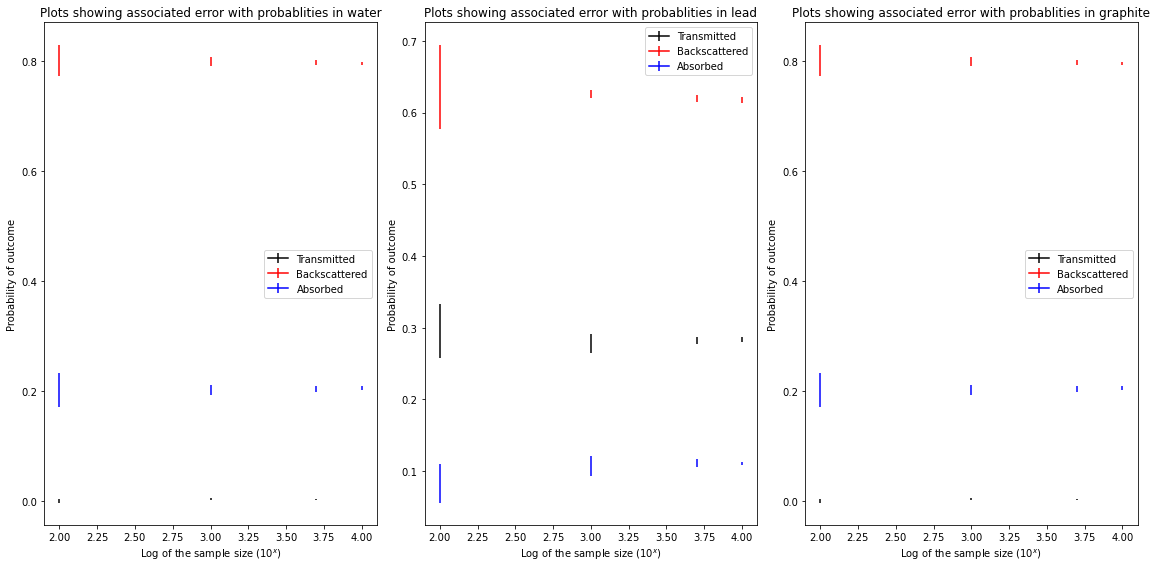

In [91]:
sample_size_plot(np.log10(sample_nums), total_w_values, total_l_values, total_g_values, total_w_std, total_l_std, total_g_std)


Altough some errors are too small to be seen at high $N$, it is clear that the error reduces as N increases. We will study this further in the following table.

In [92]:
w_percent_err = total_w_std/total_w_values * 100

print('Table showing the percentage error on each outcome for different sample sizes in water')
data = [[sample_nums[0], w_percent_err[0][0], w_percent_err[0][1], w_percent_err[0][2]],
        [sample_nums[1], w_percent_err[1][0], w_percent_err[1][1], w_percent_err[1][2]],
        [sample_nums[2], w_percent_err[2][0], w_percent_err[2][1], w_percent_err[2][2]],
        [sample_nums[3], w_percent_err[3][0], w_percent_err[3][1], w_percent_err[3][2]]]


prob_df = pd.DataFrame(data, columns=["Sample size", "Transmission % Error ",
                                      "Back Scatter % Error", "Absorption % Error"])
                                    
prob_df.round(2)





Table showing the percentage error on each outcome for different sample sizes in water


,Sample size,Transmission % Error,Back Scatter % Error,Absorption % Error
0,100,244.95,3.43,15.30
1,1000,45.49,1.03,4.75
2,5000,43.11,0.63,2.43
3,10000,8.81,0.40,1.77


As seen in these logarithmic graphs and table, the percentage error greatly reduces as you increse the sample size. This goes back to our discussion in section 1.3 about the binominal error calculation and how it is proportional to $1/\sqrt N$.




## 2.4 Attenuation Lengths in various materials
We next look at varying the thickness of the material our neutrons are propogating through in order to study the attenuation lengths in water, lead and graphite. To this we need to write a new function that will call our probability function multiple times for various values of thickness. From there we can study how the transmission probability changes with length, and thus calculate a value for the **distance characteristic** of the material. The **distance characteristic** is the length of material required to reduce the intensity of the incoming neutrons by $1/e$. Thus a more attenuating material will have a shorter distance characteristic.

The distance characeristic can be found from the equation [3]
$$I = I_0 e^{-\frac{x}{\alpha}},$$
where $I$ is the intensity of the beam after travelling through distance $x$ of the material, $I_0$ is the initial intensity and $\alpha$ is the distance characteristic. This can be found exactly the same as the free mean path, by creating a log plot, and finding the gradient to be $-\frac{1}{\alpha}.$


In [93]:
def VaryingSlabThickness(num_neutrons, T_array, iterations = 7):
    '''
    Function to generate probabilities for an array of thicknesses.
    Parameters:
    num_neutrons - number of neutrons in each sample - integer
    T_array - array of thicknesses - array of floats
    iterations - how many times to run the Probabilities function
    -------
    Returns:
    total_probs - matrix of mean probabiltity for each thickness value - ndarray
    total_std - matrix of standard deviation for each thickness value - ndarray
    '''
    total_probs = np.zeros((3,20))
    total_std = np.zeros((3,20))
    #For each thickness calculate the mean and std of probabiltities
    for index, T in enumerate(T_array):
        w_probs, l_probs, g_probs = Probabilities(num_neutrons, iterations, T)
        
        total_probs[:,index] = [np.mean(w_probs[:,0]), np.mean(l_probs[:,0]), np.mean(g_probs[:,0])]

        total_std[:,index] = [np.std(w_probs[:,0]), np.std(l_probs[:,0]), np.std(g_probs[:,0])]
       
    return total_probs, total_std


In [94]:
def probability_thickness_plot(total_probs, T_array, errs):
    '''
    Function to generate plot of probabiltity of transmission for each 
    Parameters:
    total_probs - matrix of mean probabilities - np.ndarray of floats
    T_array - array of thickness values - array of floats
    err - matrix of standard deviations - np.ndarray of floats
    -------
    Outputs:
    One errorbar plot for each material.
    '''
    fig = plt.figure(figsize=(8,8))
    
    ax = fig.add_subplot(111)
    labels = ['Water', 'Lead', 'Graphite']
    colours = ['royalblue', 'firebrick', 'slategray']
    ax.set_title("Transmission Probability")
    ax.set_xlabel('Thickness (cm)')
    ax.set_ylabel('Probability')
    
    for material in range(3):

        ax.errorbar(T_array, total_probs[material,:], label=labels[material],
                    c=colours[material], fmt='.', yerr = errs[material,:])
            
        ax.legend()
    plt.plot()
        
     

We now run these functions

In [95]:
graphite_total_probs = []

water_total_probs =[]
lead_total_probs = []
num_neutrons = 1000
L_min =1  #cm
L_max =11#cm
L_grid=20 #number of grid points within the given L range, spaced logarithmically
T_array=np.geomspace(L_min,L_max,num=L_grid)

total_trans_probs, total_trans_errs = VaryingSlabThickness(num_neutrons, T_array)




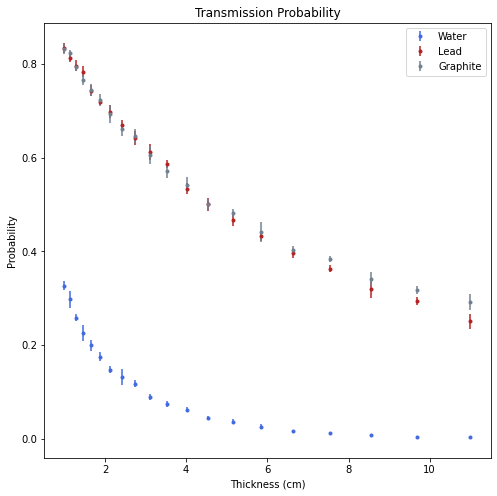

In [96]:
probability_thickness_plot(total_trans_probs, T_array, total_trans_errs)


It is clear that the transmission probabilities follow an exponential distribution, as expected from the theory discussed earlier. To calculate the attenuation characteristics we now need to calculate the gradient of these graphs, as we have done previously.

In [97]:
def LogFit(x_data, y_data, y_err, threshold = 0):
    '''
    Function to perform a fit on exponential data
    Parameters:
    x_data - x data - array of floats
    y_data - y data - array of floats
    y_err - array of standard deviations on y values - array of floats
    threshold - threshold cut off value - float
    --------
    Returns:
    coef - coeficcients of straight line plot - array of floats
    cov - covariance matrix of errors - np.ndarray of floats
    x_data - x data up to cut off value - array of floats
    ln_y_data - logged y data up to cut off value - array of floats
    ln_errs - logarithmic errors on y - array of floats
    '''
    #Find cut off value
    up_to = np.where(y_data<=threshold)[0]

    if up_to.size > 0:
        #get rid of data after first 0th value
        x_data = x_data[:up_to[0]]
        y_data = y_data[:up_to[0]]
        y_err = y_err[:up_to[0]]
    #log the y values
    ln_y_data = np.log(y_data)
    #calculate the converted errors 
    ln_errs = y_err/y_data
    
    coef, cov = np.polyfit(x_data, ln_y_data, 1, cov=True, w =  1/ln_errs)
       
    return coef, cov, x_data, ln_y_data, ln_errs

In [98]:
def ReducedChi(y_data, y_fit, y_err):
    '''
    Function to perform a reduced chi squared on a fit
    Parameters:
    y_data - y data - array of floats
    y_fit - y data for the fitted line - array of floats
    y_err - y errors on the data - array of floats
    Returns:
    reduced chi squared of data - float'''
    return(np.sum(((y_data - y_fit)/y_err)**2)/(len(y_data)-1))

In [99]:
def AttenuationCharacteristic(intensities, T_array, trans_errs):
    '''
    Function to plot a straight line graph of attenuation for each material
    Parameters:
    intensities - mean probabilites of transmission for each thickness for each material - np.ndarray
    T_array - array of thicknesses - array of floats
    trans_errs - standard deviations of probabilties for each thickness for each material - np.ndarray
    Returns:
    coefs - array of gradients of graphs
    covs - array of uncertainty on mean free path for each material 
    '''
    labels = ['Water', 'Lead', 'Graphite']
    titles = ['Transmission Probability', 'Back Scatter Probability', 'Absorption Probability']
    colours = ['royalblue', 'firebrick', 'slategray']

    fig = plt.figure(figsize=(20,7))
    
    ax_transmit = fig.add_subplot(131)
    ax_back = fig.add_subplot(132)
    
    ax_absorb = fig.add_subplot(133)
    axes = [ax_transmit, ax_back, ax_absorb]
    
    coefs = np.zeros(3)
    errs = np.zeros(3)
    chis = np.zeros(3)
    for material_index in range(3):
        coef, err, x_data, ln_y_data, ln_errs = LogFit(T_array, intensities[material_index], trans_errs[material_index])

        chi = ReducedChi(ln_y_data, coef[0]*x_data + coef[1], ln_errs)
        
        axes[material_index].errorbar(x_data, ln_y_data, yerr = ln_errs, c='black', fmt= '.', label='Errors on each bin')
        
        
        axes[material_index].plot(x_data, coef[0]*x_data + coef[1],
                                  c=colours[material_index],
                                  label=r'{} - $\chi_r^2 =${:.2f}'.format(labels[material_index], chi))
        
        
        axes[material_index].legend(prop={'size': 15})
        coefs[material_index] = coef[0]
        errs[material_index] = np.sqrt(err[0][0])/(coef[0]**2)
        axes[material_index].set_xlabel('Thickness of material')
        axes[material_index].set_ylabel(r'$\ln$ of the transmission probability')
        axes[material_index].set_title('Plot of Thickness vs Ln(Transmission %)')
        
        
    plt.show()
    return coefs, errs

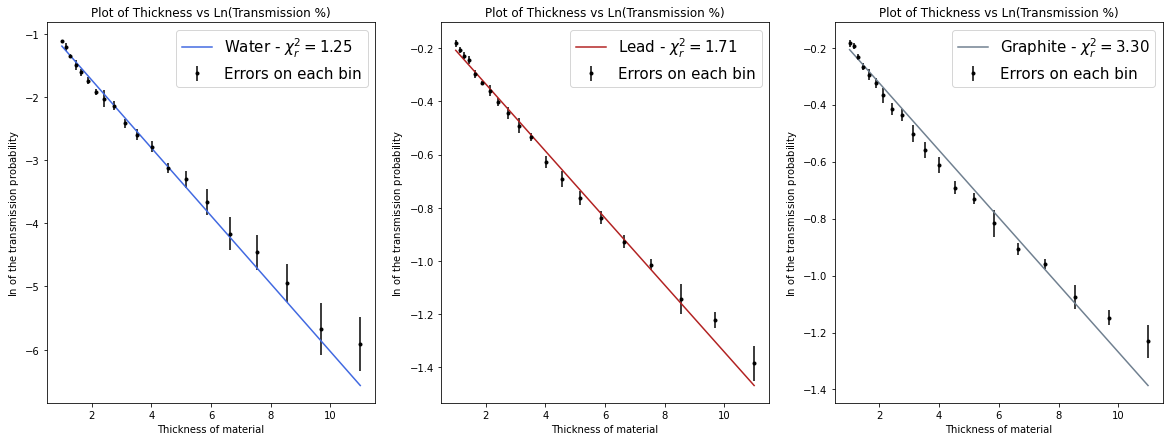

In [100]:
coefs,errs = AttenuationCharacteristic(total_trans_probs, T_array, total_trans_errs)

Here we show the logged transmission probability as thickness varies. We have also fitted the data using a weighting of $1/\sigma$, where $\sigma$ is the error on the data point. This has provided us with the values for attenuation length below. The chi square values have also been plotted, showing that water and lead are best lines of fit, whereas graphite varies quite a bit more. This is expected as it has a lower density, it's transmission rate can vary quite a lot with thickness due to the nature of a longer mean free path.

In [101]:
data = [["Water", -1/coefs[0], (errs[0]), 100*errs[0]*(-coefs[0]) ], 
        ["Lead", -1/coefs[1],(errs[1]), 100*errs[1]*(-coefs[1])],
        ["Graphite", -1/coefs[2], (errs[2]), 100*errs[2]*(-coefs[2])]]
atten_df = pd.DataFrame(data, columns=["Material", "Attenuation length", "Uncertainty", "% Uncertainty"])

atten_df.round(3)

,Material,Attenuation length,Uncertainty,% Uncertainty
0,Water,1.861,0.047,2.530
1,Lead,7.940,0.164,2.067
2,Graphite,8.485,0.234,2.757


This table summarises the findings from the above plots. Here we can see that water is far more attenuating than both lead and graphite which, from a basic view, could be quite suprising as lead is much denser than water and is normally assossiated with being attenuating because of that (for example in gamma-ray and x-ray attenuation). The real reason for water being much more attenuation is due to its much larger total cross-section which is ~10 times bigger than the other two materials. This causes each neutron to be much more likely to be scattered, increasing the scattering and therefore making the neutron much more likely to be absorbed before it is transmitted or backscattered. The percentage errors on each value are quite similar, however once again water has less variations once again due to, as described above, there on average being more steps, reducing the randomness that is inherent in the isotropic steps. 

## 3. Woodcock Method

In 1965, Alexander Woodcock proposed a different method of simulation neutrons in materials [4]. This method allows us to simulate multi Using this method we first calculate the **majorant cross-section**, which is the maximum total cross-section a material has. We then use the mean free path relatiing to this **majorant cross-section** to calculate our steps in the multi-material simulation. However as these steps are now too small when the neutron isnt in the majorant material. To counteract this we introduce a probabilitity of a fictitious step will be chosen to be
$$p[f] = \frac{\sum _T - \sum _i}{\sum _T},$$
where $\sum _T$ is the majorant cross-section $\sum _i$ the cross-section of material that the neutron moving in. If $\sum _T = \sum _i$ the probability of a fictitious step will be zero. Alternatively if the other material is a vacuum, $\Sigma _i$ will be zero, making the chance of a fictious step to be 1. We can use this property to check if our Woodcock method works as expected.
When a fictitious step happens, we generate an exponential step in **the same direction** as it was going in. This makes sense intuitively, as you don't want any scattering if the step is fictitious.

In a similar fashion to Section 2.1 we create a function to generate path histories in the systems first. To do this we create our stop checker as before which again returns the state depending on the $x$ position.  We then have to write a material checker, which returns what material our neutron is currently in. We also have our fictitious checker which uses a uniform random generator and returns *True* or *False* depending on if it is greater than or less than the probabilities described above. We also have our absorption checker, which is seperate to the stop checker, as we don't want to have a chance of absorption if we are doing a fictitious check.

In [102]:
def WcStopCheck(x, T):
    '''
    Function to determine the interaction that occurs when a neutron collides.
    Parameters :
    x - posititon of neutron - float
    T - maximum thickness (x direction) of material - float
    ---------
    Returns:
    state - Transmitted, Back Scattered or Scattered 
            depending on the outcomes of the multiple if statements
    '''
    if x > T:
        return 'Transmitted'
    elif x < 0:
        return 'Back Scattered'
    else: 
        return 'Scattered'

def MaterialCheck(x, boundary_x_array):
    '''
    Function to determine which material a neutron is in
    Parameters :
    x - posititon of neutron - float
    boundary_x_array - array of  thicknesses of materials - array of float
    ---------
    Returns:
    material - index of material (0, 1, ....)
    '''
    for material in range(len(boundary_x_array)-1):
        if boundary_x_array[material] <= x < boundary_x_array[material+1]:
            return material
        
def FictitiousCheck(u, macro_x_array, material):
    '''
    Function to determine if neutron undergoes a fictitious step
    Parameters:
    u - uniform random number - float
    macro_x_array - array of macro cross sections for each material - array of floats
    material - index of material
    -------
    Returns:
    True if fictitious
    False if real
    '''
    if u > macro_x_array[material]/np.max(macro_x_array):
        return True
    else:
        return False
def AbsorbCheck(u, abs_cross, scat_cross ):
    '''
    Function to determine if a neutron is absorbed
    Parameters :
    u - uniform random number - float
    abs_cross - absorption cross section of material - float
    scat_cross - scattering cross section of material - float
    ---------
    Returns:
    True - if neutron is absorbed
    '''
    if u < abs_cross/(abs_cross + scat_cross):
        return True


In [103]:
def WoodcockMethod(densities, molar_masses, absorb_cross_array, scat_cross_array, boundary_x_array, store=True):
    '''
    Function to generate the path of a neutron as it travels through matter using woodcock method
    Parameters :
    densities - array of densities of materials - array of floats
    molar_masses - array of molar masses of materials - array of floats
    absorb_cross_array - absorption cross-section array for materials - array of floats
    scat_cross_array - scattering cross-section array for materials - array of floats
    boundary_x_array - array of  thicknesses of materials - array of float
    ---------
    Returns:
    x_array, y_array, z_array - arrays of x, y and z for each step the neutron takes - arrays of floats
    current_state - The state of the neutron - returned from the last call of WcStopCheck - string
    count - the amount of steps the neutron has taken before ending - int
    '''
    crosssection_array = absorb_cross_array + scat_cross_array
    num_molecules_array = N_A*np.divide(densities, molar_masses, out=np.zeros_like(densities), where=molar_masses!=0)
    num_molecules_array[np.isnan(num_molecules_array)] = 0 #Catch case of vacuum
    
    
    macro_x_array = crosssection_array*num_molecules_array #Capital sigma
    min_pos = np.argmax(macro_x_array) #Position of the minimum MFP and majorant cross section

    T = boundary_x_array[-1]
    
   
    x = ExponentialRandomDist(1, densities[min_pos], molar_masses[min_pos], crosssection_array[min_pos])[0]
    dx = x
    dy = 0
    dz = 0
    y=0
    z=0
    x_path = [0, x]
    y_path = [0, 0]
    z_path = [0, 0] 
    
    P_a = np.random.uniform()
    P_f = np.random.uniform()
    
    current_state = WcStopCheck(x, T)
    count = 0
    fic_count = 0
    l = 0
    while current_state == 'Scattered':
        material = MaterialCheck(x, boundary_x_array)
        
        if FictitiousCheck(P_f, macro_x_array, material):
            fic_count +=1
            step_dist = ExponentialRandomDist(1, densities[min_pos], molar_masses[min_pos], crosssection_array[min_pos])[0]
            dR = step_dist * np.array([dx, dy, dz]) / (np.sqrt(dx**2 + dy**2 + dz**2))
            x += dR[0]
            y += dR[1]
            z += dR[2]
        elif AbsorbCheck(P_a, absorb_cross_array[material], scat_cross_array[material]):
            current_state = "Absorbed"
            break
        else:
            dx, dy, dz = IsoExponentialStepsDist(1, densities[min_pos], molar_masses[min_pos], crosssection_array[min_pos])
            dx = dx[0]
            dy = dy[0]
            dz = dz[0]
            
            x += dx
            y += dy
            z += dz
            count += 1
        x_path.append(x)
        y_path.append(y)
        z_path.append(z)

        P_a = np.random.uniform()
        P_f = np.random.uniform()

        current_state = WcStopCheck(x, T)
    return x_path, y_path, z_path, current_state, count
    
    



        
        
        

## 3.1 Neutron histories


We now need to choose what multi-material systems to use and create our arrays of values. Here are the releveant cross sections of our materials. It is better to have the material with the **majorant cross-section** second, to allow transmission into the second material to happen.

| Material      | Cross Section |
| :---:        |    :----:   |
| Vacuum      | 0       | 
| Water   | 3.46        | 
| Lead   | 0.375        | 
| Graphite   | 0.397        | 


We have decided to model vacuum into water, water into vacuum (to see if there is any distinguishable difference or weird effects at the boundary), vacuum into lead, lead into water, graphite into water and lead into graphite.


In [104]:
num_neutrons = 1000
vacuum_values_array = [0, 0, 0, 0]

vacuum_water = np.transpose(np.vstack((vacuum_values_array, water_values_array)))
water_vacuum = np.transpose(np.vstack((water_values_array, vacuum_values_array)))

vacuum_lead = np.transpose(np.vstack((vacuum_values_array, lead_values_array)))
lead_water = np.transpose(np.vstack((lead_values_array, water_values_array)))
graphite_water = np.transpose(np.vstack((graphite_values_array, water_values_array)))
lead_graphite = np.transpose(np.vstack((lead_values_array, graphite_values_array)))



boundary_x_array = np.array([0,5, 15])

v_w_path_arrays, v_w_steps= NeutronPathFinder(WoodcockMethod, *vacuum_water, boundary_x_array)
l_w_path_arrays, l_w_steps= NeutronPathFinder(WoodcockMethod, *lead_water, boundary_x_array)
g_w_path_arrays, g_w_steps= NeutronPathFinder(WoodcockMethod, *graphite_water, boundary_x_array)
l_g_path_arrays, l_g_steps = NeutronPathFinder(WoodcockMethod, *lead_graphite, boundary_x_array)



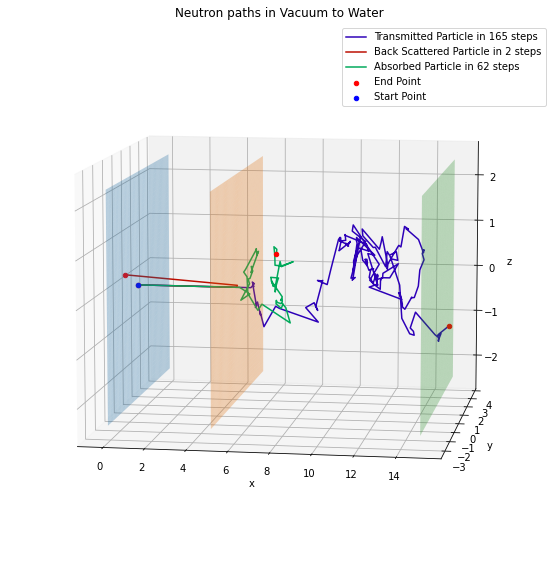

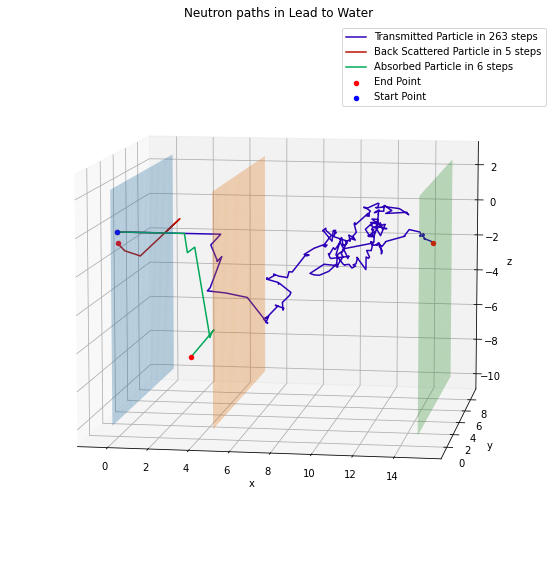

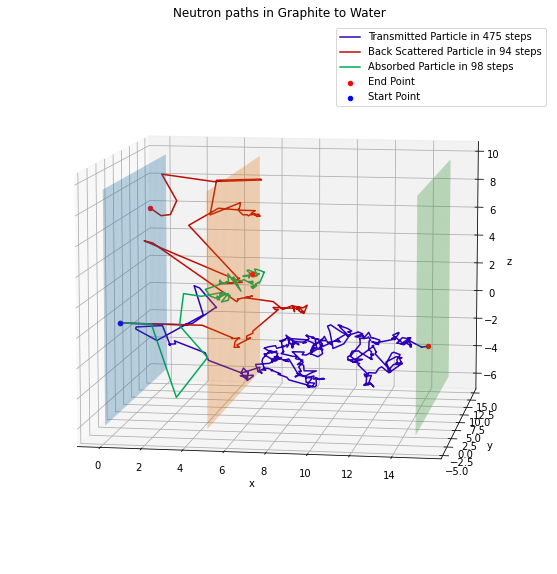

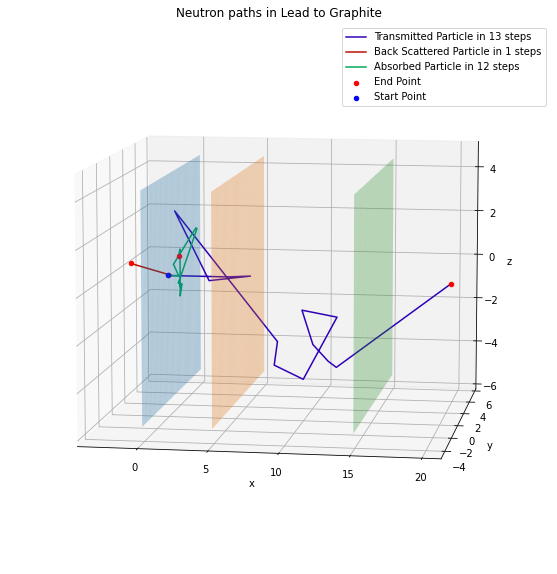

In [105]:
NeutronPathPlot('Vacuum to Water', v_w_path_arrays, boundary_x_array, v_w_steps)
NeutronPathPlot('Lead to Water', l_w_path_arrays, boundary_x_array, l_w_steps)
NeutronPathPlot('Graphite to Water', g_w_path_arrays, boundary_x_array, g_w_steps)
NeutronPathPlot('Lead to Graphite', l_g_path_arrays, boundary_x_array, l_g_steps)


## 3.2 Probabilities of interactions with neutrons

We now write a function that can simulate multiple neutrons at once similar to our single material simulations written earlier. 

First we pass in and calculate the **majorant cross-section** and thus the minimum mean free path. We also need an array of the position of each neutron, such that each element in our position array has a defined cross section and absorption/fictitous step probability.

We then create our position array, which is a np.ndarray with 3 elements for each direciton. Despite the reduced efficiency, this is needed to calculate what direction the neutron is travelling in during our fictitious step. Once again our first step is only in the $x$ direction. We also have, like in section 2.2,  random number generators for our absorption checker, as well as the fictitious step checker.

The process is very similar to simulations in one material, however there a few things that we have to do each step, for example we have to get which material each neutron is in such that we can correctly check if it has been absorbed or had a fictitious step, we also need to make two '$dR$' steps - the distances added to each position for a real and ficitious step. We also store the last total '$dR$' such that we can correctly add on the right amount for a fictious step, as described in the above paragraph.

Doing all of these steps, many of which include creating new arrays slows down this simulation, and as such it is quite a bit slower than Section 2.2. Given more time it might have been possible to optimise this more.


In [106]:
def SimulateNeutronsWC(num_neutrons, densities, molar_masses, absorb_cross_array,
                              scat_cross_array, boundary_x_array):
    '''
    Function to simulate multiple neutrons in multi-material systems:
    Parameters:
    num_neutrons - number of neutrons to simulate - integer
    densities - array of densities of materials - array of floats
    molar_masses - array of molar masses of materials - array of floats
    absorb_cross_array - absorption cross-section array for materials - array of floats
    scat_cross_array - scattering cross-section array for materials - array of floats
    boundary_x_array - array of  thicknesses of materials - array of float
    -------
    Returns:
    transmission probability - float %
    backscattering probability - float %
    absoprtion probability - float %
    '''
    num_transmit = 0
    num_backscatter = 0
    num_absorb = 0
    
    crosssection_array = absorb_cross_array + scat_cross_array
    num_molecules_array = N_A*np.divide(densities, molar_masses, out=np.zeros_like(densities), where=molar_masses!=0)
    num_molecules_array[np.isnan(num_molecules_array)] = 0 #Catch case of vacuum
    
    
    macro_x_array = np.array(crosssection_array*num_molecules_array) #Capital sigma
    min_pos = np.argmax(macro_x_array) #Position of the minimum MFP and majorant cross section
    min_dense= densities[min_pos]
    min_molar_mass = molar_masses[min_pos]
    min_cross = crosssection_array[min_pos]
    max_macro = macro_x_array[min_pos]
    
    
    material_loc = np.zeros(num_neutrons)
    T = boundary_x_array[-1]
    #last_1x_pos = np.zeros(num_neutrons)
    pos = [np.array(ExponentialRandomDist(num_neutrons, min_dense, min_molar_mass, min_cross)),np.zeros(num_neutrons), np.zeros(num_neutrons)]


    for i in range(len(boundary_x_array)-1):
        max_x = boundary_x_array[i+1]
        min_x = boundary_x_array[i]
        material_loc = np.where((pos[0] <= max_x) & (pos[0] > min_x), int(i), 0)
    
    
    abs_prob = np.divide(absorb_cross_array[material_loc], crosssection_array[material_loc],
                             out=np.zeros_like(absorb_cross_array[material_loc]), where=crosssection_array[material_loc]!=0)
    total_dR = pos
    while len(pos[0]) != 0:

        ####
        abs_rand = np.random.uniform(0, 1, len(pos[0]))

        num_transmit += len(np.argwhere(pos[0]>T))
        num_backscatter += len(np.argwhere(pos[0]<0))
        num_absorb += len(np.argwhere(abs_rand<abs_prob))
        
        
        del_index = np.where( (pos[0]>T) | (pos[0]<0) | (abs_rand<abs_prob))
        
        total_dR = [np.delete(total_dR[0], del_index),np.delete(total_dR[1], del_index),np.delete(total_dR[2], del_index)]
        
        pos = [np.delete(pos[0], del_index),np.delete(pos[1], del_index),np.delete(pos[2], del_index)]
        ####Deleted pos
        ###Redefining variables with new length
        
        for i in range(len(boundary_x_array)-1):
            max_x = boundary_x_array[i+1]
            min_x = boundary_x_array[i]
            material_loc = np.where((pos[0] <= max_x) & (pos[0] > min_x), int(i), 0)

        abs_prob = np.divide(absorb_cross_array[material_loc], crosssection_array[material_loc],
                             out=np.zeros_like(absorb_cross_array[material_loc]), where=crosssection_array[material_loc]!=0)  
        fict_rand =  np.random.uniform(0, 1, len(pos[0]))
        
        real_dR = np.array(IsoExponentialStepsDist(len(pos[0]), min_dense, min_molar_mass, min_cross))
            
        fict_dR = ([total_dR[0], total_dR[1], total_dR[2]] * ExponentialRandomDist(len(pos[0]), min_dense, min_molar_mass, min_cross) 
                   / np.sqrt(total_dR[0]**2 + total_dR[1]**2 + total_dR[2]**2))
        
        #fict_dx = np.sign(x_pos - last_1x_pos) * ExponentialRandomDist(len(x_pos), min_dense, min_molar_mass, min_cross) *.9
        #last_1x_pos = x_pos
        
        total_dR = np.where(fict_rand<macro_x_array[material_loc]/max_macro,real_dR, fict_dR)
        
        pos += total_dR
        
        
        
        #Not fictitional
        #fict_dx = (last_1x_pos - last_2x_pos)
        #fict_dx = np.where(fict_rand>macro_x_array[material_loc]/max_macro, fict_dx, 0) #Fictitional

        #x_pos += real_dx + fict_dx
    return (num_transmit/num_neutrons*100, num_backscatter/num_neutrons*100, num_absorb/num_neutrons*100)
        
        

In [107]:
boundary_x_array = np.array([0,10, 20])

w_v_probs = SimulateNeutronsWC(2000, *water_vacuum, boundary_x_array)
boundary_x_array = np.array([0,10,20])

v_w_probs = SimulateNeutronsWC(2000, *vacuum_water, boundary_x_array)
v_l_probs = SimulateNeutronsWC(2000, *vacuum_lead, boundary_x_array)
l_w_probs = SimulateNeutronsWC(2000, *lead_water, boundary_x_array)
g_w_probs = SimulateNeutronsWC(6000, *graphite_water, boundary_x_array)
l_g_probs = SimulateNeutronsWC(2000, *lead_graphite, boundary_x_array)



### Table of transmission, back scatter and absorption probability for multi-material simulations

Here are the results for when the thickness of the first material 

In [108]:
thicknesses = np.diff(boundary_x_array)
data = [["Water ("+str(thicknesses[1])+"cm)", "Vacuum("+str(thicknesses[0])+"cm)", w_v_probs[0], w_v_probs[1], w_v_probs[2]],
        ["Vacuum ("+str(thicknesses[0])+"cm)", "Water("+str(thicknesses[1])+"cm)", v_w_probs[0], v_w_probs[1], v_w_probs[2]], 
        ["Vacuum ("+str(thicknesses[0])+"cm)", "Lead("+str(thicknesses[1])+"cm)", v_l_probs[0], v_l_probs[1], v_l_probs[2]], 
        ["Lead ("+str(thicknesses[0])+"cm)", "Water("+str(thicknesses[1])+"cm)", l_w_probs[0], l_w_probs[1], l_w_probs[2]], 
        ["Graphite ("+str(thicknesses[0])+"cm)", "Water("+str(thicknesses[1])+"cm)", g_w_probs[0], g_w_probs[1], g_w_probs[2]],
        ["Lead ("+str(thicknesses[0])+"cm)", "Graphite("+str(thicknesses[1])+"cm)", l_g_probs[0], l_g_probs[1], l_g_probs[2] ]]

prob_df = pd.DataFrame(data, columns=["First Material (thicknesses)", "First Material (thicknesses)", "Transmission probability",
                                      "Back Scatter probability", 
                                      "Absorption probability"])

prob_df.round(2)

,First Material (thicknesses),First Material (thicknesses),Transmission probability,Back Scatter probability,Absorption probability
0,Water (10cm),Vacuum(10cm),0.30,78.50,21.70
1,Vacuum (10cm),Water(10cm),0.40,80.20,19.40
2,Vacuum (10cm),Lead(10cm),28.75,61.40,10.45
3,Lead (10cm),Water(10cm),0.00,39.60,61.20
4,Graphite (10cm),Water(10cm),0.27,78.92,20.93
5,Lead (10cm),Graphite(10cm),15.30,69.80,15.90


# Conclusion


In conclusion this report has shown how different materials can vary the trajectories that neutrons take. It has shown how different materials ultimately different attenuation lengths or distance characteristics which can help nuclear physicists decide what attenuating material to use. For example if they couldn't water and had to choose between lead and graphite, they can see through this report that there is little difference in the distance characteristic, however lead is much denser, so if weight was an issue graphite would be the better choice. 

We have also started to simulate multi-material systems, this is much more important, as it is rare to just have one surronding material. Given more time a possible improvement on this report would be to investigate multi-material systems in more detail, errors on each system could have been calculated, as we did in section 2.2. Additionally we could have looked into more than two material systems and varied the thickness. Another improvement could have been to consider more complicated geometry, as you can never have an infinite slab. For example we could have simulated a spherical shell or cylinder, as neutrons are normally produced in cylindrical rods inside nuclear reactors. This would enable this report to relate more to real life scenarios.

Section 2.3 could have shown some more analysis on how the error varies with sample size by calculating the gradient of the decreasing percentage error and relating that back to the theory I had explained.

In [109]:
x = datetime.now() - start_time
print("This Program Took {:.1f} s To Run.".format(x.total_seconds()))

This Program Took 43.1 s To Run.


## References

[1] - Phillips, C. "The Binomial Distribution" Mathematics Learning Centre, University of Sydney vol. 1 (2006)

[2] - Marsaglia, G. “Random numbers fall mainly in the planes.” Proceedings of the National Academy of Sciences of the United States of America vol. 61,1 (1968): 25-8.

[3] - Adib, M. & Habib N. "Attenuation of Thermal Neutrons by Crystalline Silicon" Faculty of education Ain Shams University, Cairo, Egypt vol. 1, (2001)

[4] - Woodcock, E. R. “Techniques used in the GEM Code for Monte Carlo Neutronics Calculations in Reactors and Other Systems of Complex Geometry,” Proceedings Conference Application of Computing Methods to Reactor Problems, ANL-7050, Argonne National Laboratory, (1965).